In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt
import matplotlib.cm as colormap
plt.rcParams['image.cmap'] = 'Paired'

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception,preprocess_input

# Disable GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyImagesWidth"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (Xception notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = Xception(weights='imagenet', input_shape=image_shape, include_top=False)

In [7]:
filename = 'virussign-xceptionfeatures.npy'
if os.path.exists(filename):
    print("Loading Xception extracted features from %s ..." %(filename))
    xceptionfeatures = np.load(filename)
else:
    print("Extracting features from Xception layers ...")
    xceptionfeatures = base_model.predict(X)
    print("Saving Xception extracted features into %s ..." %(filename))
    np.save(filename, xceptionfeatures)

Loading Xception extracted features from virussign-xceptionfeatures.npy ...


In [8]:
xceptionfeatures.shape

(10136, 7, 7, 2048)

In [9]:
xceptionfeatures = np.reshape(xceptionfeatures,(xceptionfeatures.shape[0],-1))

In [10]:
xceptionfeatures.shape

(10136, 100352)

In [11]:
# Training top_model
C_range = np.logspace(-2, 10, 13)
param_grid = dict(C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)

top_model = GridSearchCV(svm.LinearSVC(), param_grid=param_grid, cv=cv, verbose=10, n_jobs=5)
top_model.fit(xceptionfeatures,y)  # Training 

Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] C=0.01 ..........................................................
[CV] ........................... C=0.01, score=0.902367, total=72.8min
[CV] C=0.1 ...........................................................
[CV] ........................... C=0.01, score=0.888560, total=72.9min
[CV] C=0.1 ...........................................................
[CV] ........................... C=0.01, score=0.892505, total=75.7min
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed: 76.5min


[CV] ........................... C=0.01, score=0.886095, total=74.2min
[CV] C=0.1 ...........................................................
[CV] ........................... C=0.01, score=0.890039, total=78.8min
[CV] C=0.1 ...........................................................
[CV] ............................ C=0.1, score=0.892505, total=72.6min
[CV] C=1.0 ...........................................................
[CV] ............................ C=0.1, score=0.888560, total=83.2min
[CV] C=1.0 ...........................................................
[CV] ............................ C=0.1, score=0.901381, total=89.0min


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed: 166.3min


[CV] C=1.0 ...........................................................
[CV] ............................ C=0.1, score=0.889546, total=88.7min
[CV] C=1.0 ...........................................................
[CV] ............................ C=0.1, score=0.886095, total=88.6min
[CV] C=1.0 ...........................................................
[CV] ............................ C=1.0, score=0.888067, total=62.6min
[CV] C=10.0 ..........................................................
[CV] ............................ C=1.0, score=0.892012, total=73.7min
[CV] C=10.0 ..........................................................
[CV] ............................ C=1.0, score=0.900888, total=79.7min
[CV] C=10.0 ..........................................................
[CV] ............................ C=1.0, score=0.889546, total=73.3min
[CV] C=10.0 ..........................................................
[CV] ............................ C=1.0, score=0.886588, total=83.6min


[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed: 259.1min


[CV] C=10.0 ..........................................................
[CV] ........................... C=10.0, score=0.901381, total=63.4min
[CV] C=100.0 .........................................................
[CV] ........................... C=10.0, score=0.890533, total=68.0min
[CV] C=100.0 .........................................................
[CV] ........................... C=10.0, score=0.889546, total=72.0min
[CV] C=100.0 .........................................................
[CV] ........................... C=10.0, score=0.888067, total=72.7min
[CV] C=100.0 .........................................................
[CV] ........................... C=10.0, score=0.886588, total=75.1min
[CV] C=100.0 .........................................................
[CV] .......................... C=100.0, score=0.901381, total=77.7min
[CV] C=1000.0 ........................................................
[CV] .......................... C=100.0, score=0.889546, total=64.8min


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed: 385.2min


[CV] C=1000.0 ........................................................
[CV] .......................... C=100.0, score=0.892012, total=78.5min
[CV] C=1000.0 ........................................................
[CV] .......................... C=100.0, score=0.888067, total=75.5min
[CV] C=1000.0 ........................................................
[CV] .......................... C=100.0, score=0.886095, total=75.7min
[CV] C=1000.0 ........................................................
[CV] ......................... C=1000.0, score=0.888067, total=63.9min
[CV] C=10000.0 .......................................................
[CV] ......................... C=1000.0, score=0.901381, total=74.7min
[CV] C=10000.0 .......................................................
[CV] ......................... C=1000.0, score=0.892012, total=69.9min
[CV] C=10000.0 .......................................................
[CV] ......................... C=1000.0, score=0.889546, total=74.0min
[CV] C

[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 522.1min


[CV] C=100000.0 ......................................................
[CV] ........................ C=10000.0, score=0.891519, total=70.6min
[CV] C=100000.0 ......................................................
[CV] ........................ C=10000.0, score=0.887574, total=70.6min
[CV] C=100000.0 ......................................................
[CV] ........................ C=10000.0, score=0.889546, total=72.5min
[CV] C=100000.0 ......................................................
[CV] ........................ C=10000.0, score=0.886588, total=78.2min
[CV] C=100000.0 ......................................................
[CV] ....................... C=100000.0, score=0.901874, total=64.3min
[CV] C=1000000.0 .....................................................
[CV] ....................... C=100000.0, score=0.887574, total=64.7min
[CV] C=1000000.0 .....................................................
[CV] ....................... C=100000.0, score=0.891519, total=76.6min
[CV] C

[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 659.5min


[CV] C=1000000.0 .....................................................
[CV] ...................... C=1000000.0, score=0.892012, total=67.0min
[CV] ....................... C=100000.0, score=0.886095, total=76.5min
[CV] C=10000000.0 ....................................................
[CV] C=10000000.0 ....................................................
[CV] ...................... C=1000000.0, score=0.887574, total=73.1min
[CV] C=10000000.0 ....................................................
[CV] ...................... C=1000000.0, score=0.889546, total=75.1min
[CV] C=10000000.0 ....................................................
[CV] ...................... C=1000000.0, score=0.886095, total=73.6min
[CV] C=10000000.0 ....................................................
[CV] ..................... C=10000000.0, score=0.901874, total=70.6min
[CV] C=100000000.0 ...................................................
[CV] ..................... C=10000000.0, score=0.892012, total=74.6min
[CV] C

[Parallel(n_jobs=5)]: Done  51 tasks      | elapsed: 811.2min


[CV] C=1000000000.0 ..................................................
[CV] .................... C=100000000.0, score=0.901381, total=74.5min
[CV] C=1000000000.0 ..................................................
[CV] .................... C=100000000.0, score=0.887081, total=70.1min
[CV] C=1000000000.0 ..................................................
[CV] .................... C=100000000.0, score=0.889546, total=73.8min
[CV] C=1000000000.0 ..................................................
[CV] .................... C=100000000.0, score=0.886095, total=67.2min
[CV] C=1000000000.0 ..................................................
[CV] ................... C=1000000000.0, score=0.901381, total=71.0min
[CV] C=10000000000.0 .................................................
[CV] ................... C=1000000000.0, score=0.891519, total=69.0min
[CV] C=10000000000.0 .................................................
[CV] ................... C=1000000000.0, score=0.887574, total=66.1min
[CV] C

[Parallel(n_jobs=5)]: Done  63 out of  65 | elapsed: 973.6min remaining: 30.9min


[CV] .................. C=10000000000.0, score=0.889546, total=72.3min
[CV] .................. C=10000000000.0, score=0.886588, total=62.4min


[Parallel(n_jobs=5)]: Done  65 out of  65 | elapsed: 1010.9min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=1, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=5,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [12]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 0.01} - score: 0.8919


In [13]:
top_model.cv_results_

{'mean_fit_time': array([ 4475.7054184 ,  5060.16187077,  4465.93352904,  4185.01216636,
         4454.80551262,  4296.12886019,  4312.48904004,  4230.88167644,
         4248.5116878 ,  4257.04509463,  4208.36221619,  4170.17527223,
         4085.45459757]),
 'mean_score_time': array([ 16.60924501,   5.65215478,   9.04180818,  28.79546223,
         11.56039801,   5.20499263,   6.81089149,  48.45364838,
         13.83460317,  12.0486145 ,  15.36353683,  13.47379141,  19.75260482]),
 'mean_test_score': array([ 0.89191321,  0.89161736,  0.89142012,  0.89122288,  0.89142012,
         0.89122288,  0.89142012,  0.8913215 ,  0.89112426,  0.89142012,
         0.89112426,  0.89122288,  0.89142012]),
 'mean_train_score': array([ 0.99982733,  0.99982733,  0.99982733,  0.99982733,  0.99982733,
         0.99982733,  0.99982733,  0.99982733,  0.99982733,  0.99982733,
         0.99982733,  0.99982733,  0.99982733]),
 'param_C': masked_array(data = [0.01 0.10000000000000001 1.0 10.0 100.0 1000.0 10000

In [14]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.89191, std: 0.00563, params: {'C': 0.01},
 mean: 0.89162, std: 0.00530, params: {'C': 0.10000000000000001},
 mean: 0.89142, std: 0.00506, params: {'C': 1.0},
 mean: 0.89122, std: 0.00525, params: {'C': 10.0},
 mean: 0.89142, std: 0.00534, params: {'C': 100.0},
 mean: 0.89122, std: 0.00555, params: {'C': 1000.0},
 mean: 0.89142, std: 0.00549, params: {'C': 10000.0},
 mean: 0.89132, std: 0.00558, params: {'C': 100000.0},
 mean: 0.89112, std: 0.00504, params: {'C': 1000000.0},
 mean: 0.89142, std: 0.00554, params: {'C': 10000000.0},
 mean: 0.89112, std: 0.00547, params: {'C': 100000000.0},
 mean: 0.89122, std: 0.00534, params: {'C': 1000000000.0},
 mean: 0.89142, std: 0.00549, params: {'C': 10000000000.0}]

In [15]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
svm_model = svm.LinearSVC(C=top_model.best_params_['C'])
train_sizes = np.linspace(.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(svm_model, xceptionfeatures, y, cv=cv, n_jobs=5, train_sizes=train_sizes)

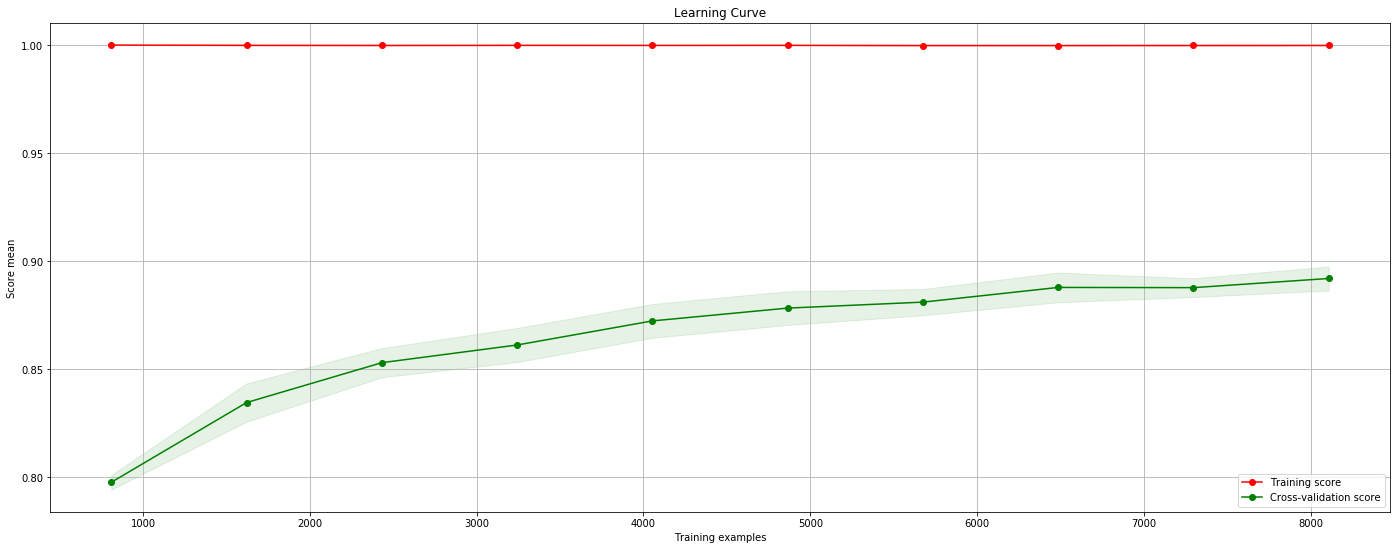

In [16]:
figure = plt.gcf()
figure.set_size_inches(24, 9)
skplot.learning_curve(train_scores, test_scores, train_sizes)
plt.show()